<a href="https://colab.research.google.com/github/mridulbiswas402/entropy-based-stegnography/blob/main/chapter6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 6**

***Implementation Details and Results***






In [1]:
from math import log
from math import e
from tqdm import tqdm
from math import log10, sqrt
from scipy import stats
import binascii
import cv2 
from numpy import asarray
from math import floor
import numpy as np 
from google.colab.patches import cv2_imshow  
import matplotlib.pyplot as plt 
%matplotlib inline
import os
import pandas as pd

***Functions to compute various metrics of the original and processed image.***

*   *Function MSE() computes mean square error.*
*   *Function PSNR() computes peaksignal to noise ration.*
*   *Function BPP() computes optimal amount of bits that can be embedded per pixel of a give region in image.*


In [2]:

def metrics(original,output,imageid):
    bpp = BPP(original)
    mse = MSE(original,output)
    snr = SNR(original,output)
    psnr = PSNR(original,output)
    noofpix = len(edgeloc(original))
    dat = (bpp*noofpix)/8
    return imageid,bpp,mse,snr,psnr,dat


def MSE(output,input):
   # print(output.shape,input.shape)
    difference_array = np.subtract(output, input)
    squared_array = np.square(difference_array)
    mse = squared_array.mean()
    return mse

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr  

def SNR(original, compressed):
    mse = np.sum((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = np.sum(np.square(original))
    snr = 20 * log10(max_pixel / mse)
    return snr

def BPP(grayimagearray):
    edgpix = edgepixval(grayimagearray)
    noofbit = floor(log(np.std(edgpix),e))
    return noofbit     

***Functions to compute edge pixel location of the given image.***

*   *Function  edgeloc() returns list of form [(x1,y1),(x2,y2),(x3,y3)...] such that (xi,yi) belongs to location of edge region of image*
*   *Function calcmask() computes mask to embed variable amount of bits in image pixel*


In [3]:
def edgeloc(imagearray):
    edges = cv2.Canny(imagearray,100,200)  # canny edge detection algo is used
    row,col=edges.shape
    lst=[]
    for i in range(1,row):
      for j in range(col):
        if(edges[i,j]>=250):
          lst.append((i,j))  
    return lst 

def edgepixval(imagearray):
    edgloc=edgeloc(imagearray)
    edglst=[]
    l = len(edgloc)
    for k in range(l):
      i,j=edgloc[k]
      edglst.append(imagearray[i,j])
    return np.array(edglst)  


def calcmask(grayimagearray):
    edgpix = edgepixval(grayimagearray)
    noofbit = floor(log(np.std(edgpix),e))
    mask = ''
    for i in range(8-noofbit):
      mask=mask+'1'
    for i in range(noofbit):
      mask = mask + '0'  
    return int(mask,2)  


def statistics(imgdata,binary,encodefunc):     # imgdata is dataframe
  entry = len(imgdata)
  score = list()
  for i in tqdm(range(entry)):
    image = cv2.imread(imgdata["path"][i]) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    temp=gray.copy()
    mask = calcmask(gray)
    temp= encodefunc(binary,temp,mask)
    score.append(metrics(gray,temp,imgdata["imageid"][i]))
  colnames=["Image_ID","BPP","MSE","SNR","PSNR","DATA"]  
  return  pd.DataFrame(score,columns=colnames)





***Below function are use to convert message to binary string and vice versa.***


In [4]:

def str2bin(message):
    binary = bin(int(binascii.hexlify(message.encode("ascii")), 16))
    return binary[2:]  

def bin2str(binary):
	message = binascii.unhexlify('%x' % (int('0b'+binary,2)))
	return message

***Functions to embed and extract more than one bit from LSB of a pixel value.***

*   *Function  varbitemb() embeds variable amount of bits in pixels depending upon value of mask for example if mask = 0b11111000  --> 3 bits has to be embedded  i.e no of zeros in binary representation of mask = no of bits to be embedded or extracted.*
*   *Function varbitdecode() extracts variable amout of bits from the pixels.*

In [5]:
def varbitextr(pixel,mask):
    noofbits=countzeros(mask)
    dmask=mask ^ 255
    if (noofbits==1):
      return format((pixel & dmask),"0b")
    elif (noofbits==2):
      return format((pixel & dmask),"02b")
    elif (noofbits==3):
      return format((pixel & dmask),"03b") 
    elif (noofbits==4):
      return format((pixel & dmask),"04b")
    else:
      print("error")     


def varbitemb(pixel,data,mask):
  return ((pixel & mask )|data)



def countzeros(mask):
  count0=0
  while (mask != 0):  
    if (mask % 2 == 0):
      count0 += 1
    mask //= 2
  return count0  


def stuffbits(binarymessage,mask):
 # print("  in function stuffbit ")
  n = countzeros(mask)
  #print("on of zero in mask = ",n)
  nbstuff = (n-(len(binarymessage) % n)) 
  #print("nbstuff = ",nbstuff)
  while (nbstuff):
    binarymessage=binarymessage+'0'
    nbstuff=nbstuff-1
  return binarymessage   


***Functions to encode and decode data from image.***

*   *Function  varbitencode() encodes data in edge location of image array from second row in row major order. 1st five pixel of 1st row is header.*
*   *Function varbitdecode() decodes data frome image array.*

***Header formate***
* imagearray[0,0]=mask
* imagearray[0,1]*256+imagearray[0,2] = no of pixel in which data are encoded
* imagearray[0,3]*256+imagearray[0,4] = data length


In [6]:
def varbitencode1(binmessage,imagearray,mask):
 # print("in function varbitencode1 ")
  row,col=imagearray.shape
 # print("row,col = ",row,col)
  noofbits= countzeros(mask)
 # print("noofbit = ",noofbits)
  lst = stuffbits(binmessage,mask)
  #lst=binmessage
  imagearray[0,0]=mask
  noofpix = format(int((len(lst)/noofbits)),'016b')
 # print("noofpix = ",int(noofpix,2))
  datalen = format(len(binmessage),'016b')
 # print("datalen = ",int(datalen,2))
  imagearray[0,1]=int(noofpix[:8],2)
  imagearray[0,2]=int(noofpix[8:],2)
  imagearray[0,3]=int(datalen[:8],2)
  imagearray[0,4]=int(datalen[8:],2)
  for i in range(1,row):
    for j in range(col):
      temp = imagearray[i,j]
      if (lst):
        data=int(lst[:noofbits],2)
        lst=lst[noofbits:]
        imagearray[i,j]=varbitemb(temp,data,mask)
      else: break
  return imagearray 


 
def varbitdecode1(imagearray):
 # print("  in function varbitdecode1  ")
  #dmask = mask ^ 255
  mask = imagearray[0,0]
 # print("mask = ",mask)
  noofpix = (256*imagearray[0,1]+imagearray[0,2])
 # print("noofpix = ",noofpix)
  datalen = (256*imagearray[0,3]+imagearray[0,4])
 # print("datalen = ",datalen)
  binmessage=''
  #noofbits= countzeros(mask)
  n = countzeros(mask)
 # print("no of zeros in mask = ",n)
  stuffedbit = (n-(datalen % n))
 # print("stuffedbit = ",stuffedbit) 
  row,col=imagearray.shape
 # print("row,col = ",row,col)

  for i in range(1,row):
    for j in range(col):
      temp = imagearray[i,j]
      binmessage=binmessage+varbitextr(temp,mask)
      noofpix=noofpix-1
      if(not noofpix):
        print('success')
        return bin2str(binmessage[:-stuffedbit])
       # print(-stuffedbit)
        #return binmessage[:-stuffedbit] to



def varbitencode2(binmessage,imagearray,mask):
 # print("in function varbitencode1 ")
  row,col=imagearray.shape
 # print("row,col = ",row,col)
  noofbits= countzeros(mask)
 # print("noofbit = ",noofbits)
  lst = stuffbits(binmessage,mask)
  #lst=binmessage
  imagearray[0,0]=mask
  noofpix = format(int((len(lst)/noofbits)),'016b')
 # print("noofpix = ",int(noofpix,2))
  datalen = format(len(binmessage),'016b')
 # print("datalen = ",int(datalen,2))
  imagearray[0,1]=int(noofpix[:8],2)
  imagearray[0,2]=int(noofpix[8:],2)
  imagearray[0,3]=int(datalen[:8],2)
  imagearray[0,4]=int(datalen[8:],2)
 ###################################
  edg = edgeloc(imagearray)
  nofedg = len(edg)
  for k in range(nofedg):
      i,j= edg[k]
      temp = imagearray[i,j]
      if (lst):
        data=int(lst[:noofbits],2)
        lst=lst[noofbits:]
        imagearray[i,j]=varbitemb(temp,data,mask)
      else: break
  return imagearray , edg

def varbitdecode2(imagearray,edg):
 # print("  in function varbitdecode1  ")
  #dmask = mask ^ 255
  mask = imagearray[0,0]
 # print("mask = ",mask)
  noofpix = (256*imagearray[0,1]+imagearray[0,2])
 # print("noofpix = ",noofpix)
  datalen = (256*imagearray[0,3]+imagearray[0,4])
 # print("datalen = ",datalen)
  binmessage=''
  #noofbits= countzeros(mask)
  n = countzeros(mask)
 # print("no of zeros in mask = ",n)
  stuffedbit = (n-(datalen % n))
 # print("stuffedbit = ",stuffedbit) 
  row,col=imagearray.shape
 # print("row,col = ",row,col)
  #edg = edgeloc(imagearray)
  nofedg = len(edg)
  for k in range(nofedg):
      i,j= edg[k]
      temp = imagearray[i,j]
      binmessage=binmessage+varbitextr(temp,mask)
      noofpix=noofpix-1
      if(not noofpix):
        print('success')
        return bin2str(binmessage[:-stuffedbit])


***DEMONSTRATION***

In [7]:
# reading image data into numpy array
image = cv2.imread('lena.png') 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  

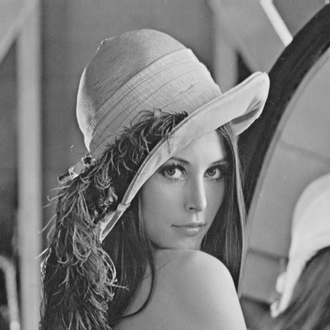

In [14]:
cv2_imshow(gray)

In [16]:
# reading data to be hidden in message from file str2bin.c
file = open('str2bin.c', encoding='ascii', errors='replace')
message = file.read()
file.close()

In [19]:
# converting message into binary string 
A=gray.copy()
binary=str2bin(message)
mask=0b11111000    # mask for embedding at a rate of 3 bit/pixel

In [20]:
# encodeing data into image
A,egdlocation=varbitencode2(binary,A,mask)

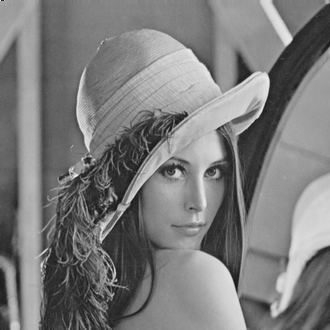

In [21]:
cv2_imshow(A)  # image after encodeing data in to it

In [22]:
mess=varbitdecode2(A,egdlocation) # decodeing data from the encoded image

success


In [23]:
mess # decoded data

b'/******************************************************************************\n\n               following code is for encodeing message into binary\n\n*******************************************************************************/\n#include <stdio.h>\n#include <stdlib.h>\n\nchar *get_bits(char n){\n    \n    char *bits = malloc(sizeof(char) * 8);\n\n    for(int k=0; k<8; k++){\n        int mask =  1 << k;\n        int masked_n = n & mask;\n        int thebit = masked_n >> k;\n        bits[k] = thebit;\n    }\n\n    return bits;\n}\nint main(){\n    \n    char mess[20];\n    char *bmes[sizeof(mess)]={NULL};\n    scanf("%[^\\n]%*c",mess);\n    int i=0;\n    while(mess[i]){\n        \n        bmes[i]=get_bits(mess[i]);\n        i++;\n    }\n    bmes[i]=get_bits(mess[i]);\n//////////////////////////////////////////////\n\n   \n    int j=0;\n    while(bmes[j]){\n        for(int i=8-1; i>=0;i--){\n            printf("%d ", bmes[j][i]);\n        }\n        free(bmes[j]);\n        printf(

In [24]:
# diffmat is difference between original image and modefied image
diffmat = np.subtract(A,gray)

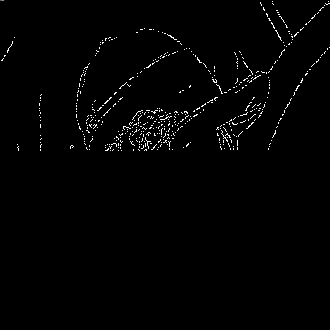

In [28]:
cv2_imshow(diffmat)  # plotting the difference image and it is clearly visible only edge pixels are modified i.e data are only hidden in edge location

***RESULT OF TEN IMAGES***

In [29]:
# formation of data set of ten images
base_image_dir ='/content/drive/MyDrive/imgdata'
df = pd.read_csv('imagedat.csv')
df['path'] = df['imageid'].map(lambda x: os.path.join(base_image_dir,'{}.tif'.format(x)))

In [30]:
df

,imageid,path
0,1,/content/drive/MyDrive/imgdata/1.tif
1,2,/content/drive/MyDrive/imgdata/2.tif
2,3,/content/drive/MyDrive/imgdata/3.tif
3,4,/content/drive/MyDrive/imgdata/4.tif
4,5,/content/drive/MyDrive/imgdata/5.tif
5,6,/content/drive/MyDrive/imgdata/6.tif
6,7,/content/drive/MyDrive/imgdata/7.tif
7,8,/content/drive/MyDrive/imgdata/8.tif
8,9,/content/drive/MyDrive/imgdata/9.tif
9,10,/content/drive/MyDrive/imgdata/10.tif


In [31]:
stats=statistics(df,binary,varbitencode1)

100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


In [32]:
# stats contains results of ten images
stats

,Image_ID,BPP,MSE,SNR,PSNR,DATA
0,1,4,0.855505,42.348905,48.808578,2019.500
1,2,3,0.067014,63.832456,59.869134,2665.500
2,3,4,0.586008,36.033476,50.451770,3045.000
3,4,3,0.116063,60.189457,57.483878,846.750
4,5,3,0.108532,60.553992,57.775227,6431.625
5,6,3,0.111202,59.569176,57.669668,5831.625
6,7,3,0.104710,60.507249,57.930938,5506.125
7,8,3,0.085644,60.660911,58.803846,2247.750
8,9,3,0.112732,60.160822,57.610334,10495.125
9,10,3,0.103947,60.379786,57.962697,20851.125


***RESULT DESCRIPTION***

*   *BPP is the optimal amout of bits that can be encoded in the image it is in unit BIT/PIXEL.*
*   *MSE is mean square error*
*   *PSNR is peak signal to noise ration in decibel*
*   *DATA is the amount of in formation that can be hidden in the image in BYTEs* 